Logistic Regression â€” Binary & Multiclass (From Scratch) + EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report)
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import os
plt.rcParams['figure.figsize'] = (6,4)
np.random.seed(42)


## Math Primer (What You'll Implement)

### 1) Binary Logistic Regression
* We map $( z = \mathbf{x}^\top\mathbf{w} + b $) through the sigmoid:
$
\sigma(z) = \frac{1}{1+e^{-z}}, \qquad \hat{y} = \sigma(z) \in (0,1).
$
<br>

* The **binary cross-entropy** with L2 regularization ($(\lambda$)) over \(N\) samples:
$
\mathcal{L}(\mathbf{w},b) = -\frac{1}{N}\sum_{i=1}^{N}\Big[y_i\log \hat{y}_i + (1-y_i)\log(1-\hat{y}_i)\Big] + \frac{\lambda}{2N}\|\mathbf{w}\|_2^2.
$

<br><br>
**Gradients**
$
\nabla_{\mathbf{w}} = \tfrac{1}{N}\mathbf{X}^\top(\hat{\mathbf{y}}-\mathbf{y}) + \tfrac{\lambda}{N}\mathbf{w}, \qquad
\nabla_b = \tfrac{1}{N}\sum_{i=1}^{N}(\hat{y}_i-y_i).
$

We then update parameters with gradient descent $( \mathbf{w}\leftarrow\mathbf{w}-\eta\nabla_{\mathbf{w}},\; b\leftarrow b-\eta \nabla_b $).




---
## Part A â€” Breast Cancer (Binary) â€” EDA

**Goal:** Understand class balance, feature distributions, correlations, and a 2D PCA view before modeling.

In [2]:
X_bc, y_bc = load_breast_cancer(return_X_y=True)
feat_bc = load_breast_cancer().feature_names
df_bc = pd.DataFrame(X_bc, columns=feat_bc)
df_bc['target'] = y_bc
print('Shape:', df_bc.shape)
print('Class counts:')
print(df_bc['target'].value_counts())

Shape: (569, 31)
Class counts:
target
1    357
0    212
Name: count, dtype: int64


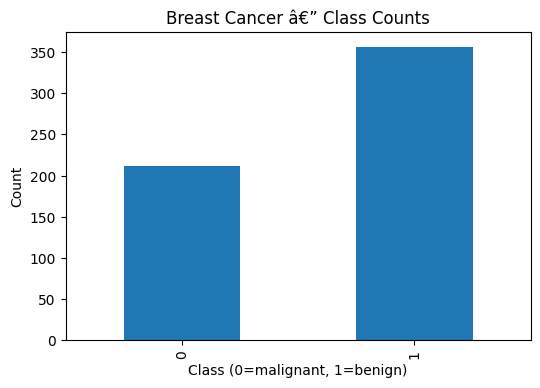

In [3]:
plt.figure(); df_bc['target'].value_counts().sort_index().plot(kind='bar');
plt.title('Breast Cancer â€” Class Counts'); plt.xlabel('Class (0=malignant, 1=benign)'); plt.ylabel('Count'); plt.show()

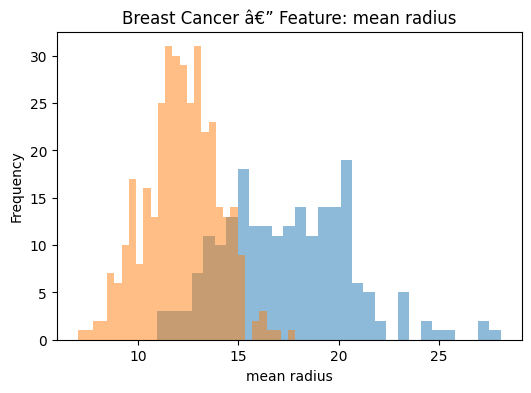

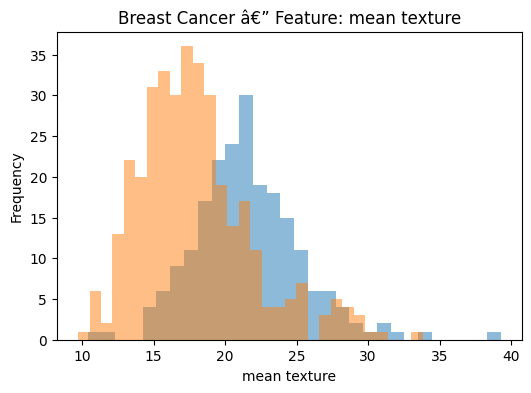

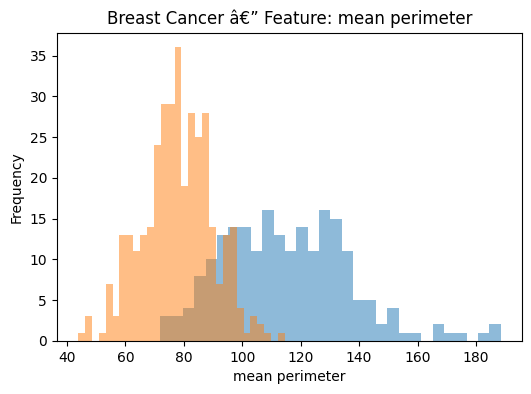

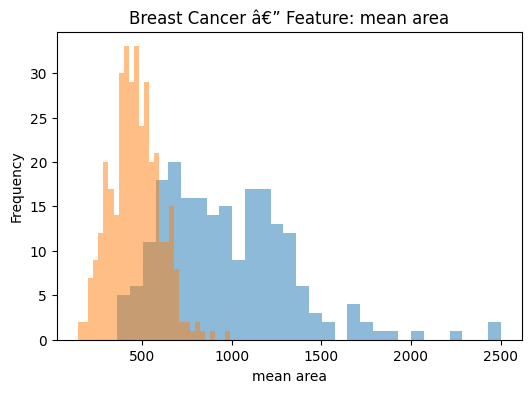

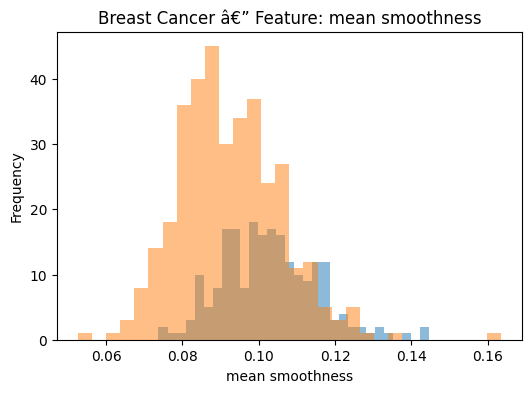

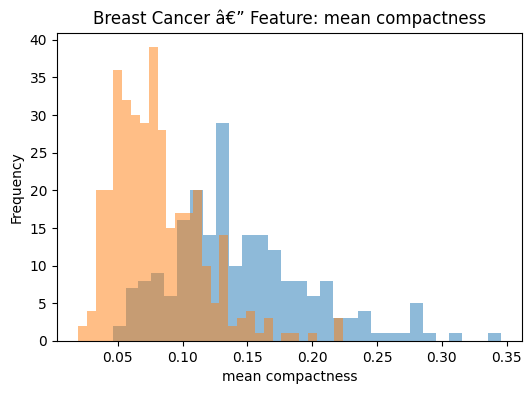

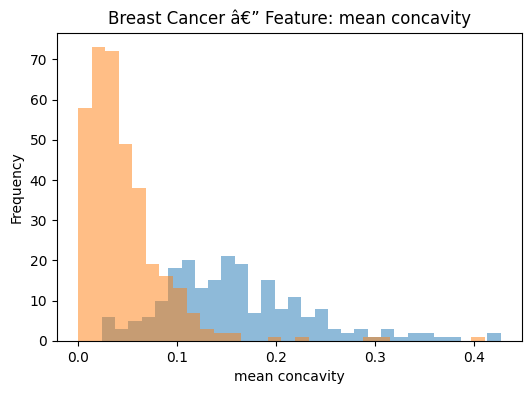

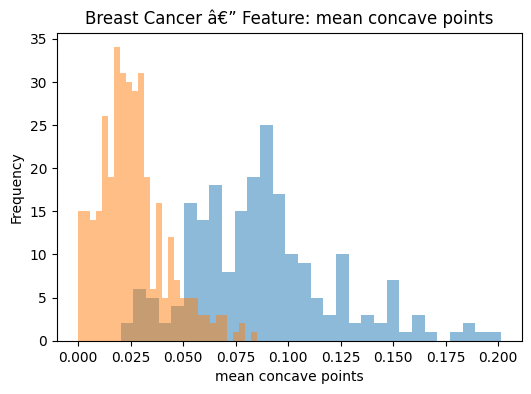

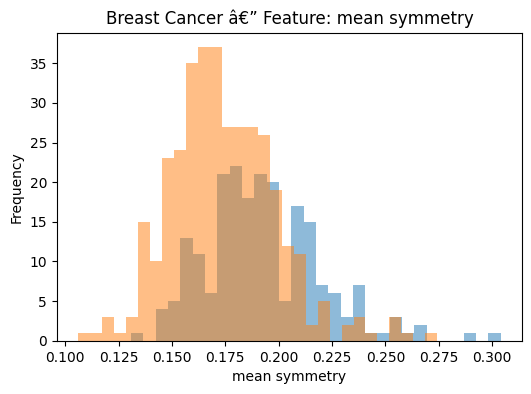

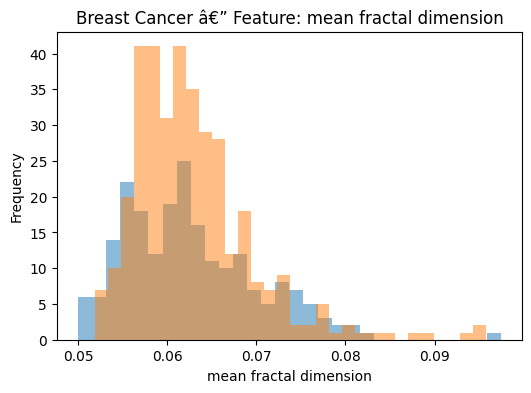

In [4]:
for col in df_bc.columns[:10]:  # show first 10 features to avoid too many plots
    plt.figure();
    df_bc[df_bc['target']==0][col].plot(kind='hist', bins=30, alpha=0.5)
    df_bc[df_bc['target']==1][col].plot(kind='hist', bins=30, alpha=0.5)
    plt.title(f'Breast Cancer â€” Feature: {col}'); plt.xlabel(col); plt.ylabel('Frequency'); plt.show()

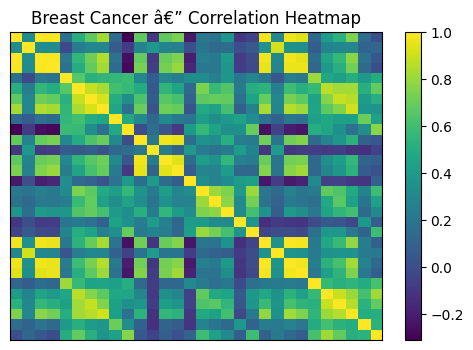

In [5]:
corr = df_bc.drop(columns=['target']).corr()
plt.figure(); plt.imshow(corr, aspect='auto'); plt.title('Breast Cancer â€” Correlation Heatmap'); plt.colorbar(); plt.xticks([]); plt.yticks([]); plt.show()

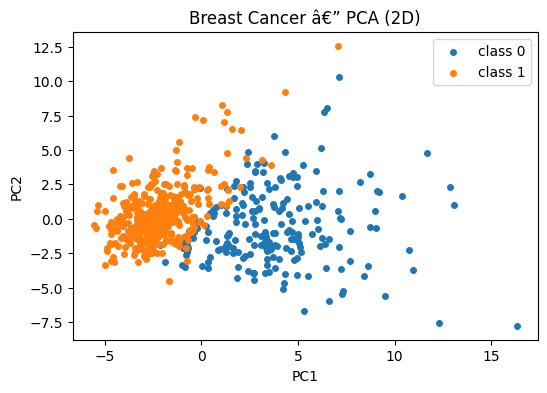

In [6]:
scaler_tmp = StandardScaler()
Z = scaler_tmp.fit_transform(df_bc.drop(columns=['target']))
Z2 = PCA(n_components=2).fit_transform(Z)
plt.figure()
for c in np.unique(y_bc):
    pts = Z2[y_bc==c]
    plt.scatter(pts[:,0], pts[:,1], s=16, label=f'class {c}')
plt.legend(); plt.title('Breast Cancer â€” PCA (2D)'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

### Modeling Setup 

In [7]:
Xtr_bc, Xva_bc, ytr_bc, yva_bc = train_test_split(X_bc, y_bc, test_size=0.25, stratify=y_bc, random_state=42)
scaler_bc = StandardScaler()
Xtr_bc_std = scaler_bc.fit_transform(Xtr_bc)
Xva_bc_std = scaler_bc.transform(Xva_bc)

In [8]:
def sigmoid(z):
    # ------------------------------------------------
    # TODO Refer to the Binary Logistic Regression Sigmoid Function defined in the Math Primer (Exercise 1)
    # You may want to use np.exp
    # ------------------------------------------------
    return 1.0/(1.0 + np.exp(-z))
    # ----------------------------
    # Implementation Ends Here
    # ----------------------------


In [9]:
def bin_loss_and_grads(X, y, w, b, lam):
    N = X.shape[0]
    z = X @ w + b
    p = sigmoid(z)
    eps = 1e-12

    # ------------------------------------------------
    # TODO Refer to the Binary Cross-Entropy Loss Function defined in the Math Primer (Exercise 2)
    # You may want to use np.exp
    # ------------------------------------------------
    ce = -np.mean(y*np.log(p + eps) + (1 - y)*np.log(1 - p + eps))
    # ----------------------------
    # Implementation Ends Here
    # ----------------------------
    reg = (lam/(2.0*N))*(w@w)
    loss = ce + reg
    gw = (X.T @ (p - y))/N + (lam/N)*w
    gb = np.mean(p - y)
    return loss, gw, gb


In [10]:
def fit_logreg_binary(X, y, lr=0.1, lam=0.01, epochs=2000, batch_size=None, verbose=True):
    N, D = X.shape; w = np.zeros(D); b = 0.0; losses = []
    for t in range(1, epochs+1):
        if batch_size is None:
            Xb, yb = X, y
        else:
            idx = np.random.choice(N, size=batch_size, replace=False); Xb, yb = X[idx], y[idx]
        loss, gw, gb = bin_loss_and_grads(Xb, yb, w, b, lam)
        w -= lr*gw; b -= lr*gb
        L,_,_ = bin_loss_and_grads(X, y, w, b, lam); losses.append(L)
        if verbose and (t % max(1, epochs//10) == 0):
            pass
    return w, b, np.array(losses)


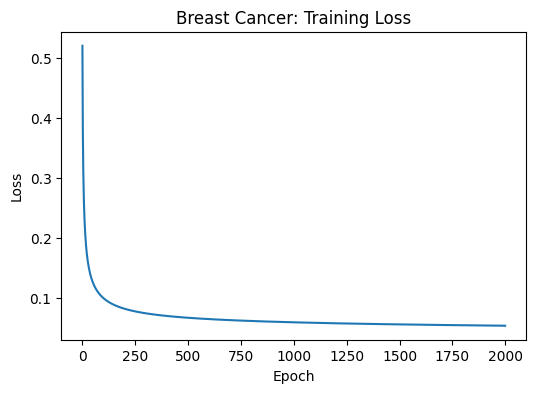

In [11]:
w_bc, b_bc, losses_bc = fit_logreg_binary(Xtr_bc_std, ytr_bc)
if len(losses_bc)>0:
    plt.figure(); plt.plot(losses_bc); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Breast Cancer: Training Loss'); plt.show()

In [12]:
def predict_proba_binary(X, w, b):
    # ------------------------------------------------
    # TODO Refer to the Binary Logistic Regression Sigmoid Function defined in the Math Primer (Exercise 3)
    # What is the Z defined as
    # ------------------------------------------------
    return sigmoid(X @ w + b)
    # ----------------------------
    # Implementation Ends Here
    # ----------------------------


In [13]:
def predict_label_binary(X, w, b, thresh=0.5):
    # ------------------------------------------------
    # TODO We want to determine the binary label of the data if it is above a certain threshold (Exercise 4)
    # You may want to return it as a type int
    # ------------------------------------------------
    return (predict_proba_binary(X, w, b) >= thresh).astype(int)
    # ----------------------------
    # Implementation Ends Here
    # ----------------------------


Breast Cancer â€” Acc/Prec/Rec/F1/AUC: 0.979 0.9888 0.9778 0.9832 0.9979


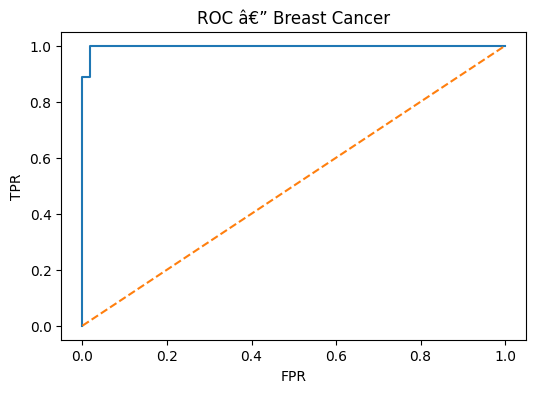

[[52  1]
 [ 2 88]]


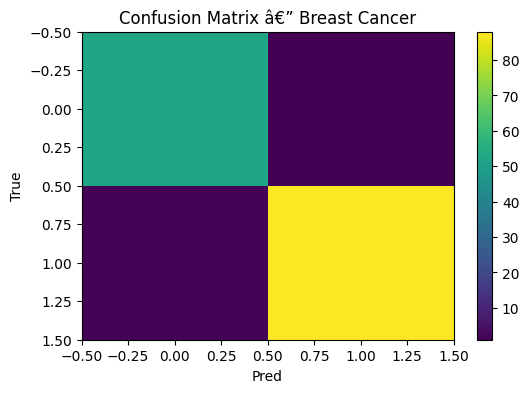

In [14]:
p_bc = predict_proba_binary(Xva_bc_std, w_bc, b_bc)
yhat_bc = predict_label_binary(Xva_bc_std, w_bc, b_bc)
print('Breast Cancer â€” Acc/Prec/Rec/F1/AUC:',
      round(accuracy_score(yva_bc, yhat_bc),4),
      round(precision_score(yva_bc, yhat_bc),4),
      round(recall_score(yva_bc, yhat_bc),4),
      round(f1_score(yva_bc, yhat_bc),4),
      round(roc_auc_score(yva_bc, p_bc),4))
fpr, tpr, _ = roc_curve(yva_bc, p_bc)
plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC â€” Breast Cancer'); plt.show()
cm = confusion_matrix(yva_bc, yhat_bc)
print(cm)
plt.figure(); plt.imshow(cm, aspect='auto'); plt.title('Confusion Matrix â€” Breast Cancer'); plt.xlabel('Pred'); plt.ylabel('True'); plt.colorbar(); plt.show()

In [15]:
# ------------------------------------------------
# TODO We will be utilizing the LogisticRegression model from sklearn, we will use a max_iter=10000 (Exercise 5)
# First we will train on our data Xtr_bc_std
# After we want to do predictions on the validation set data Xva_bc_std
# ------------------------------------------------
clf_bc = LogisticRegression(max_iter=10000)
clf_bc.fit(Xtr_bc_std, ytr_bc)
pred_bc = clf_bc.predict(Xva_bc_std)

# ----------------------------
# Implementation Ends Here
# ----------------------------

prob_bc = clf_bc.predict_proba(Xva_bc_std)[:,1]
print('sklearn ? Acc/Prec/Rec/F1/AUC:',
      round(accuracy_score(yva_bc, pred_bc),4),
      round(precision_score(yva_bc, pred_bc),4),
      round(recall_score(yva_bc, pred_bc),4),
      round(f1_score(yva_bc, pred_bc),4),
      round(roc_auc_score(yva_bc, prob_bc),4))


sklearn ? Acc/Prec/Rec/F1/AUC: 0.986 0.9889 0.9889 0.9889 0.9977


---
## Part B â€” Titanic (Binary) â€” EDA

**Goal:** Inspect missingness and the relationship between survival and key variables.

In [16]:
TRAIN_CSV = 'train.csv'
TEST_CSV  = 'test.csv'
if not os.path.exists(TRAIN_CSV):
    print('Place Kaggle Titanic train.csv beside the notebook to run this section.')
else:
    titanic = pd.read_csv(TRAIN_CSV)
    print('Shape:', titanic.shape)
    print(titanic.isna().sum())

Shape: (891, 12)
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


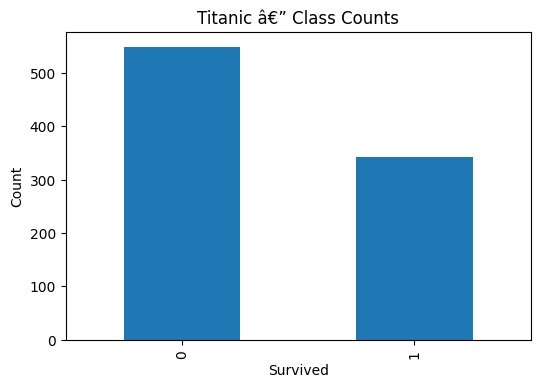

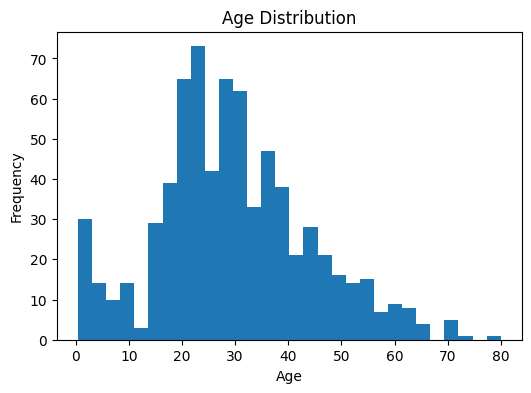

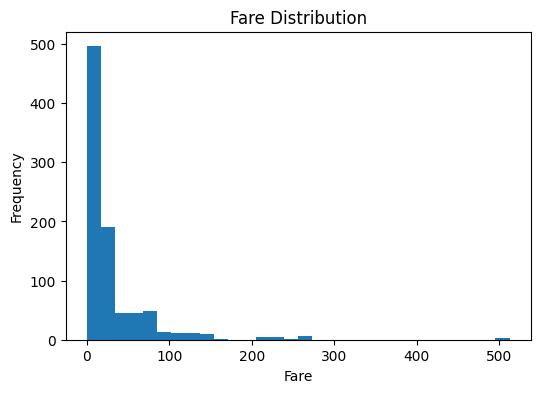

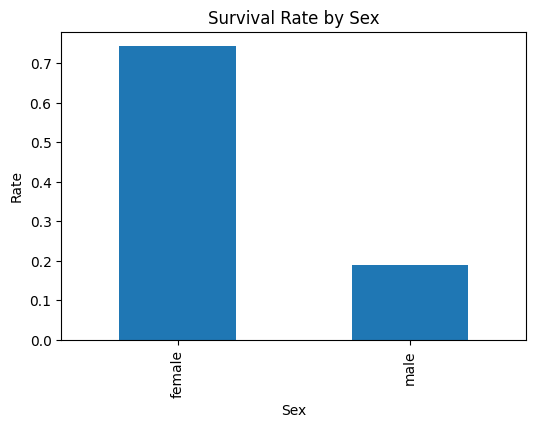

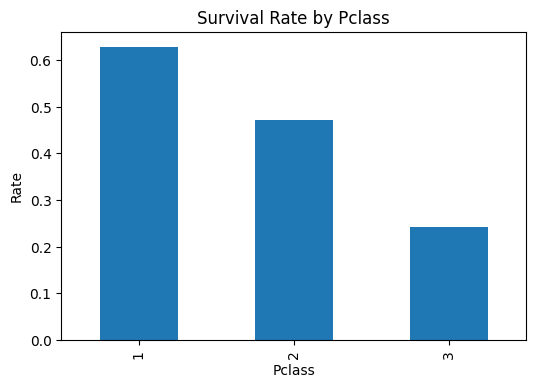

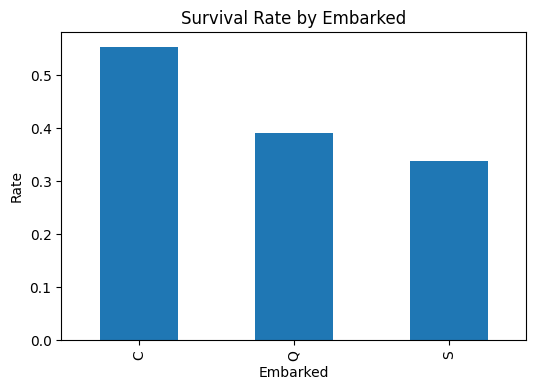

In [17]:
if os.path.exists(TRAIN_CSV):
    plt.figure(); titanic['Survived'].value_counts().sort_index().plot(kind='bar');
    plt.title('Titanic â€” Class Counts'); plt.xlabel('Survived'); plt.ylabel('Count'); plt.show()
    plt.figure(); titanic['Age'].dropna().plot(kind='hist', bins=30); plt.title('Age Distribution'); plt.xlabel('Age'); plt.show()
    plt.figure(); titanic['Fare'].dropna().plot(kind='hist', bins=30); plt.title('Fare Distribution'); plt.xlabel('Fare'); plt.show()
    plt.figure(); titanic.groupby('Sex')['Survived'].mean().plot(kind='bar'); plt.title('Survival Rate by Sex'); plt.ylabel('Rate'); plt.show()
    plt.figure(); titanic.groupby('Pclass')['Survived'].mean().plot(kind='bar'); plt.title('Survival Rate by Pclass'); plt.ylabel('Rate'); plt.show()
    if titanic['Embarked'].notna().any():
        plt.figure(); titanic.groupby('Embarked')['Survived'].mean().plot(kind='bar'); plt.title('Survival Rate by Embarked'); plt.ylabel('Rate'); plt.show()

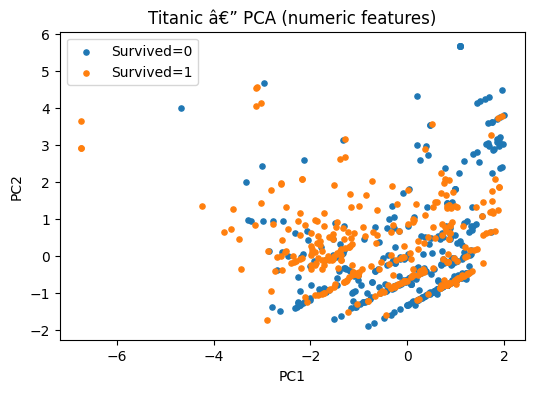

In [18]:
if os.path.exists(TRAIN_CSV):
    # Basic numeric PCA view
    num_cols = ['Pclass','Age','SibSp','Parch','Fare']
    tmp = titanic[num_cols].copy()
    tmp = tmp.fillna(tmp.median())
    Z = StandardScaler().fit_transform(tmp)
    Z2 = PCA(n_components=2).fit_transform(Z)
    y = titanic['Survived'].values
    plt.figure()
    for c in np.unique(y):
        pts = Z2[y==c]
        plt.scatter(pts[:,0], pts[:,1], s=14, label=f'Survived={c}')
    plt.legend(); plt.title('Titanic â€” PCA (numeric features)'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

### Titanic â€” Modeling (reuse binary functions)

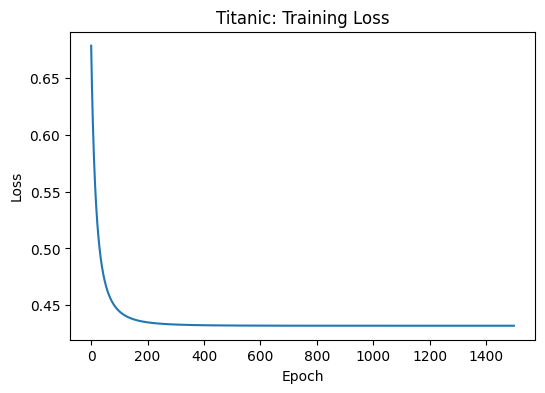

Titanic Acc/Prec/Rec/F1/AUC: 0.7758 0.7093 0.7093 0.7093 0.8401
sklearn (Titanic): 0.7713 0.7108 0.686 0.6982 0.8401


In [19]:
if os.path.exists(TRAIN_CSV):
    df = titanic.copy()
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    df['Sex'] = df['Sex'].map({'male':0,'female':1})
    df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)
    features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked_Q','Embarked_S']
    X_ti = df[features]
    y_ti = df['Survived']
    Xtr_ti, Xva_ti, ytr_ti, yva_ti = train_test_split(X_ti, y_ti, test_size=0.25, stratify=y_ti, random_state=42)
    scaler_ti = StandardScaler()
    Xtr_ti_std = scaler_ti.fit_transform(Xtr_ti)
    Xva_ti_std = scaler_ti.transform(Xva_ti)

    # ------------------------------------------------
    # TODO We will utilize the fit_logreg_binary we defined in the first part, we will be using the Xtr_ti_std as the train data (Exercise 6)
    # lr=0.1, lam=0.01, epochs=1500 and verbose=False
    # ------------------------------------------------
    w_ti, b_ti, losses_ti = fit_logreg_binary(Xtr_ti_std, ytr_ti.to_numpy(), lr=0.1, lam=0.01, epochs=1500, verbose=False)
    # ----------------------------
    # Implementation Ends Here
    # ----------------------------

    plt.figure(); plt.plot(losses_ti); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Titanic: Training Loss'); plt.show()
    p_ti = predict_proba_binary(Xva_ti_std, w_ti, b_ti)
    yhat_ti = predict_label_binary(Xva_ti_std, w_ti, b_ti)
    print('Titanic Acc/Prec/Rec/F1/AUC:', round(accuracy_score(yva_ti, yhat_ti),4), round(precision_score(yva_ti, yhat_ti),4), round(recall_score(yva_ti, yhat_ti),4), round(f1_score(yva_ti, yhat_ti),4), round(roc_auc_score(yva_ti, p_ti),4))

    clf_ti = LogisticRegression(max_iter=10000)
    clf_ti.fit(Xtr_ti_std, ytr_ti)
    pred_ti = clf_ti.predict(Xva_ti_std)
    prob_ti = clf_ti.predict_proba(Xva_ti_std)[:,1]
    print('sklearn (Titanic):', round(accuracy_score(yva_ti, pred_ti),4), round(precision_score(yva_ti, pred_ti),4), round(recall_score(yva_ti, pred_ti),4), round(f1_score(yva_ti, pred_ti),4), round(roc_auc_score(yva_ti, prob_ti),4))


---
## Part C â€” Iris (Multiclass) â€” EDA

### 2) Multiclass Logistic Regression (Softmax)
For \(K\) classes, with $(\mathbf{W}\in\mathbb{R}^{D\times K}$), $(\mathbf{b}\in\mathbb{R}^{K}$):
$
\mathbf{z} = \mathbf{W}^\top \mathbf{x} + \mathbf{b},\qquad
\hat{p}_k = \frac{e^{z_k}}{\sum_{j=1}^K e^{z_j}} = \text{softmax}(\mathbf{z})_k.
$

<br><br>
Use one-hot labels $( \mathbf{Y}\in\{0,1\}^{N\times K} $) and predictions $( \hat{\mathbf{P}}\in[0,1]^{N\times K} $):

**Total Loss Function**: $
\mathcal{L}(\mathbf{W},\mathbf{b}) = -\frac{1}{N}\sum_{i=1}^N \sum_{k=1}^K Y_{ik}\log \hat{P}_{ik} + \frac{\lambda}{2N}\|\mathbf{W}\|_F^2.
$

<br><br>
**Gradients:**
$
\nabla_{\mathbf{W}} = \tfrac{1}{N}\mathbf{X}^\top(\hat{\mathbf{P}}-\mathbf{Y}) + \tfrac{\lambda}{N}\mathbf{W}, \qquad
\nabla_{\mathbf{b}} = \tfrac{1}{N}\sum_{i=1}^{N}(\hat{\mathbf{P}}_{i\cdot}-\mathbf{Y}_{i\cdot}).
$


**Goal:** Visualize distributions and separability across the 3 classes.

In [20]:
X_ir, y_ir = load_iris(return_X_y=True)
feat_ir = load_iris().feature_names
df_ir = pd.DataFrame(X_ir, columns=feat_ir)
df_ir['target'] = y_ir
print('Class counts:', df_ir['target'].value_counts().sort_index().to_dict())

Class counts: {0: 50, 1: 50, 2: 50}


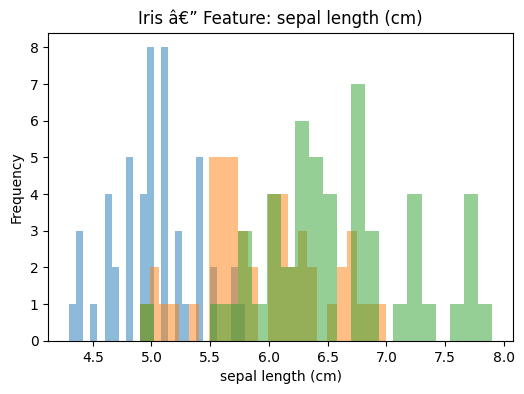

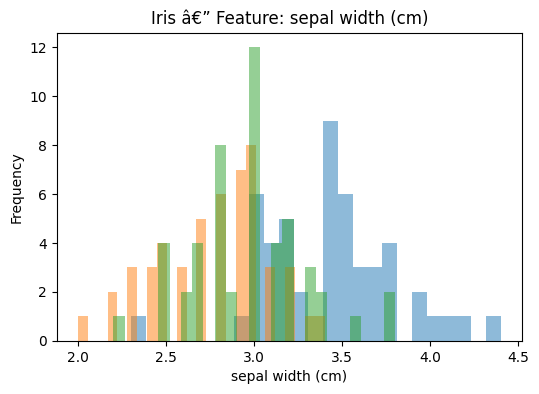

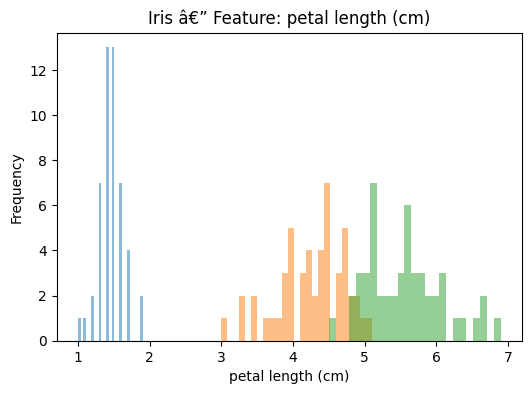

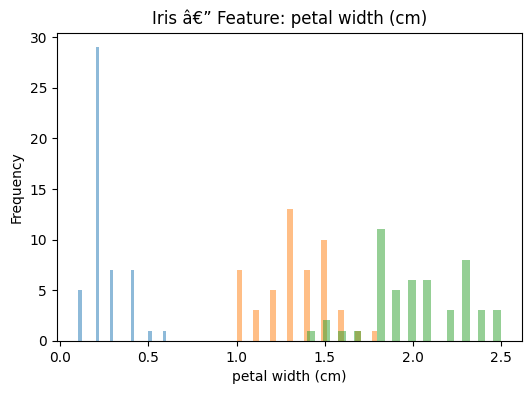

In [21]:
for col in feat_ir:
    plt.figure();
    for c in np.unique(y_ir):
        df_ir[df_ir['target']==c][col].plot(kind='hist', bins=25, alpha=0.5)
    plt.title(f'Iris â€” Feature: {col}'); plt.xlabel(col); plt.ylabel('Frequency'); plt.show()

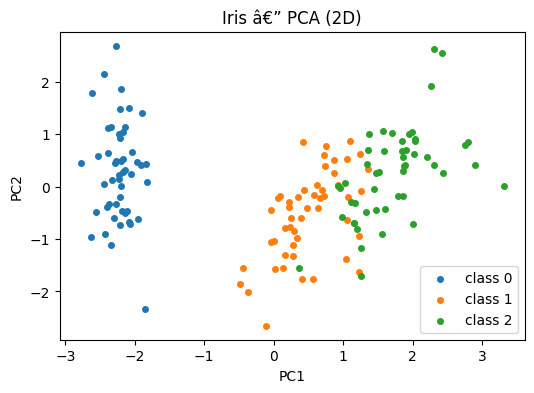

In [22]:
scaler_tmp = StandardScaler()
Z = scaler_tmp.fit_transform(df_ir.drop(columns=['target']))
Z2 = PCA(n_components=2).fit_transform(Z)
plt.figure()
for c in np.unique(y_ir):
    pts = Z2[y_ir==c]
    plt.scatter(pts[:,0], pts[:,1], s=16, label=f'class {c}')
plt.legend(); plt.title('Iris â€” PCA (2D)'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

### Iris â€” Modeling (Softmax)

In [23]:
Xtr_ir, Xva_ir, ytr_ir, yva_ir = train_test_split(X_ir, y_ir, test_size=0.25, stratify=y_ir, random_state=42)
scaler_ir = StandardScaler()
Xtr_ir_std = scaler_ir.fit_transform(Xtr_ir)
Xva_ir_std = scaler_ir.transform(Xva_ir)

In [24]:
def one_hot(y, K):
    Y = np.zeros((y.shape[0], K)); Y[np.arange(y.shape[0]), y] = 1.0; return Y


In [25]:
def softmax(Z):
    Zs = Z - Z.max(axis=1, keepdims=True)
    # ------------------------------------------------
    # TODO Refer to the Multiclass Logistic Regression Softmax section above (Exercise 7)
    # You may want to use np.exp
    # ------------------------------------------------
    expZ = np.exp(Zs)
    return expZ / expZ.sum(axis=1, keepdims=True)
    # ----------------------------
    # Implementation Ends Here
    # ----------------------------


In [26]:
def softmax_loss_and_grads(X, Y, W, b, lam):
    N = X.shape[0]
    Z = X @ W + b
    P = softmax(Z)
    eps = 1e-12
    # ------------------------------------------------
    # TODO Refer to the Multiclass Logistic Regression Total Loss function defined above (Exercise 8)
    # You may want to use np.log
    # ------------------------------------------------
    ce = -np.sum(Y*np.log(P + eps))/N
    reg = (lam/(2.0*N))*np.sum(W*W)
    # ----------------------------
    # Implementation Ends Here
    # ----------------------------

    loss = ce + reg
    dZ = (P - Y)/N
    dW = X.T @ dZ + (lam/N)*W
    db = dZ.sum(axis=0)
    return loss, dW, db


In [27]:
def fit_softmax(X, y, lr=0.1, lam=0.01, epochs=1500, batch_size=None, verbose=True):
    N, D = X.shape; K=int(y.max()+1); Y=one_hot(y,K); W=np.zeros((D,K)); b=np.zeros(K); losses=[]
    for t in range(1, epochs+1):
        if batch_size is None:
            Xb, Yb = X, Y
        else:
            idx = np.random.choice(N, size=batch_size, replace=False); Xb, Yb = X[idx], Y[idx]
        loss, dW, db = softmax_loss_and_grads(Xb, Yb, W, b, lam)
        W -= lr*dW; b -= lr*db
        L,_,_ = softmax_loss_and_grads(X, Y, W, b, lam); losses.append(L)
        if verbose and (t % max(1, epochs//10)==0):
            pass
    return W, b, np.array(losses)


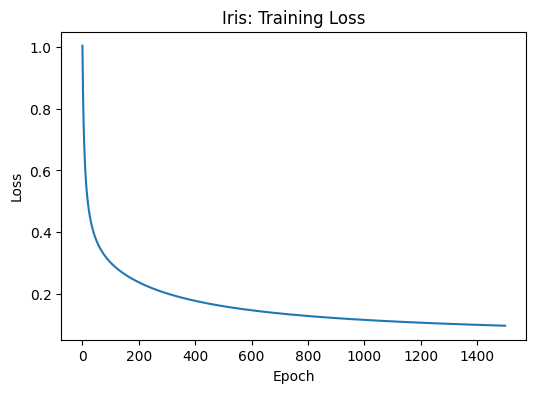

In [28]:
W_ir, b_ir, losses_ir = fit_softmax(Xtr_ir_std, ytr_ir, lr=0.1, lam=0.01, epochs=1500, verbose=True)
if len(losses_ir)>0:
    plt.figure(); plt.plot(losses_ir); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Iris: Training Loss'); plt.show()

In [29]:
def predict_proba_softmax(X, W, b):
    # TODO Refer to the Multiclass Logistic Regression Softmax section above (Exercise 9)
    # Hint what is Z defined as
    return softmax(X @ W + b)
    # ----------------------------
    # Implementation Ends Here
    # ----------------------------


In [30]:
def predict_label_softmax(X, W, b):
    return np.argmax(predict_proba_softmax(X, W, b), axis=1)


Iris accuracy: 0.9474
[[12  0  0]
 [ 0 12  1]
 [ 0  1 12]]


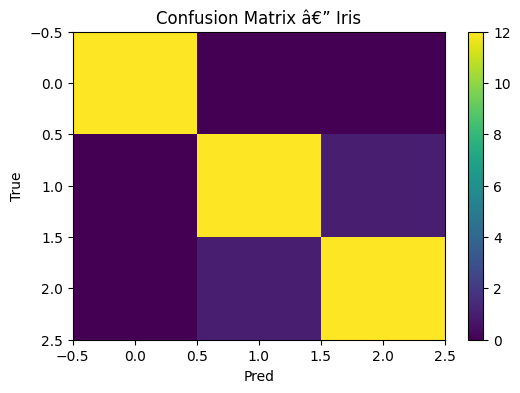

In [31]:
yp_ir = predict_label_softmax(Xva_ir_std, W_ir, b_ir)
print('Iris accuracy:', round(accuracy_score(yva_ir, yp_ir),4))
cm = confusion_matrix(yva_ir, yp_ir); print(cm)
plt.figure(); plt.imshow(cm, aspect='auto'); plt.title('Confusion Matrix â€” Iris'); plt.xlabel('Pred'); plt.ylabel('True'); plt.colorbar(); plt.show()

In [32]:
# ------------------------------------------------
# TODO We will be utilizing the LogisticRegression model from sklearn, we will use multinomial as the multi_class, lbfgs as the solver and the max_iter=2000 (Exercise 10)
# First we will train on our data Xtr_ir_std
# After we want to do predictions on the validation set data Xva_ir_std
# ------------------------------------------------
clf_ir = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000)
clf_ir.fit(Xtr_ir_std, ytr_ir)
pred_ir = clf_ir.predict(Xva_ir_std)
# ----------------------------
# Implementation Ends Here
# ----------------------------

print('sklearn (Iris) accuracy:', round(accuracy_score(yva_ir, pred_ir),4))
print(classification_report(yva_ir, pred_ir, digits=4))


sklearn (Iris) accuracy: 0.9211
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        12
           1     0.8571    0.9231    0.8889        13
           2     0.9167    0.8462    0.8800        13

    accuracy                         0.9211        38
   macro avg     0.9246    0.9231    0.9230        38
weighted avg     0.9226    0.9211    0.9209        38



c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


---
## Part D â€” Digits (Multiclass) â€” EDA

**Goal:** See sample digits, per-class averages, and separability in PCA.

Digits shape: (1797, 64)


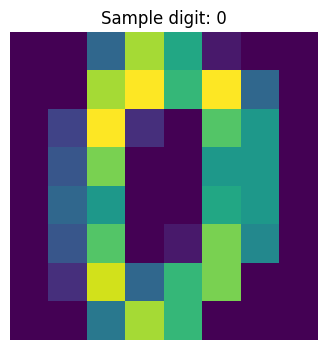

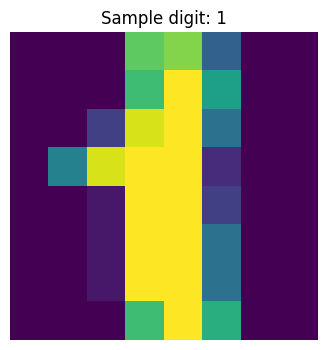

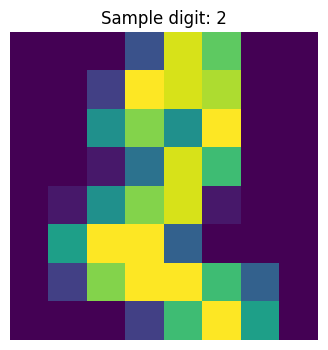

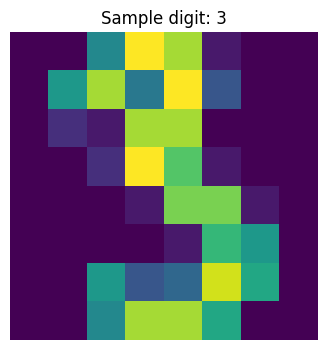

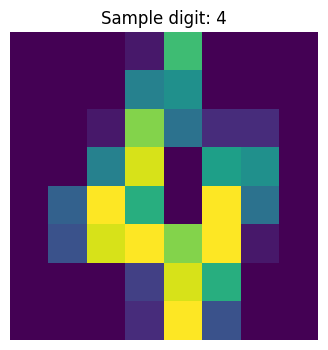

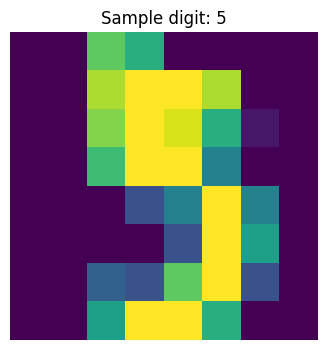

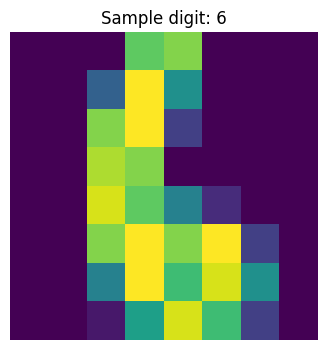

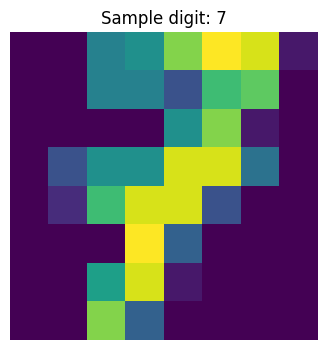

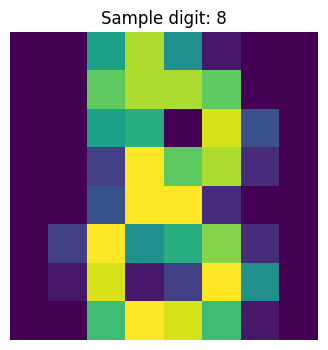

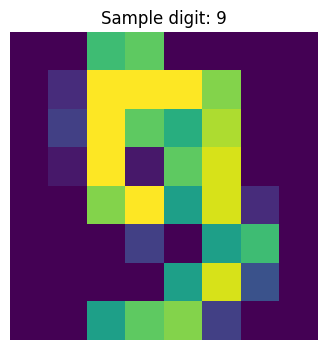

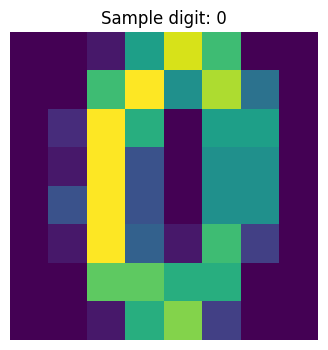

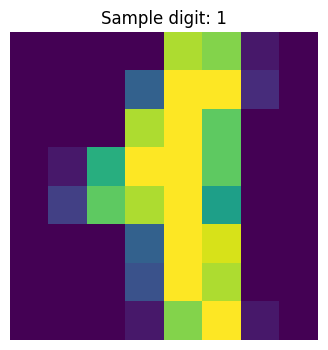

In [33]:
X_dig, y_dig = load_digits(return_X_y=True)
print('Digits shape:', X_dig.shape)
imgs = X_dig.reshape(-1, 8, 8)
for i in range(12):
    plt.figure(); plt.imshow(imgs[i], cmap=None); plt.title(f'Sample digit: {y_dig[i]}'); plt.axis('off'); plt.show()

In [34]:
avg_imgs = []
for k in np.unique(y_dig):
    avg_imgs.append(imgs[y_dig==k].mean(axis=0))
avg_imgs = np.array(avg_imgs)


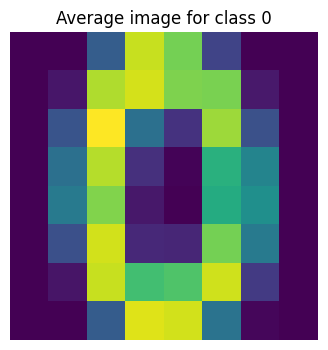

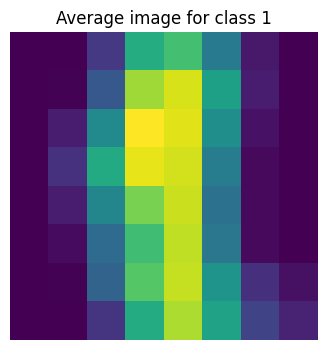

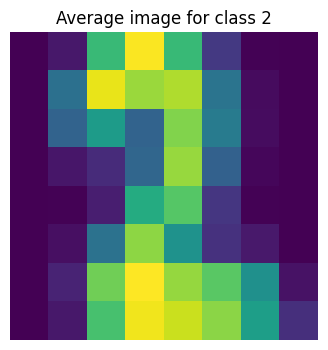

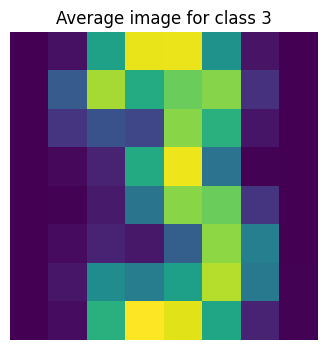

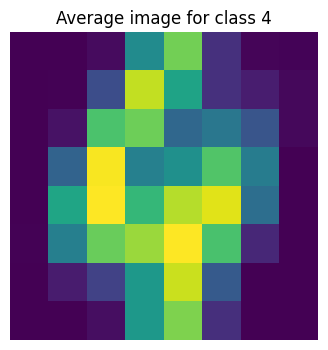

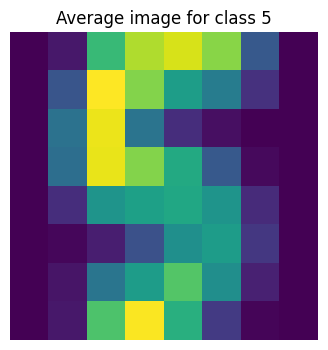

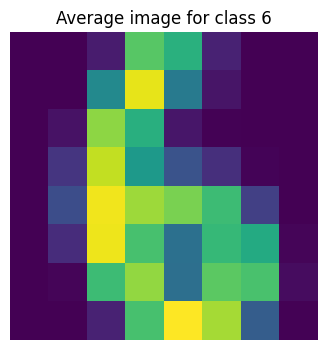

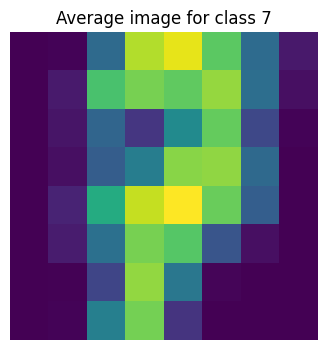

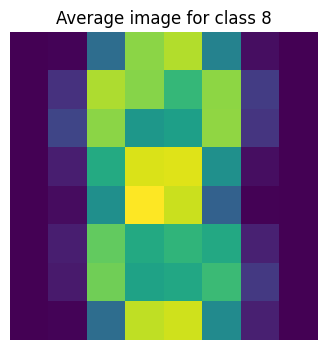

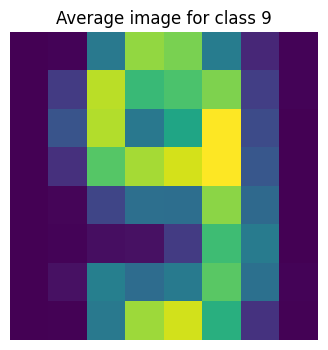

In [35]:
for k in range(avg_imgs.shape[0]):
    plt.figure(); plt.imshow(avg_imgs[k], cmap=None); plt.title(f'Average image for class {k}'); plt.axis('off'); plt.show()

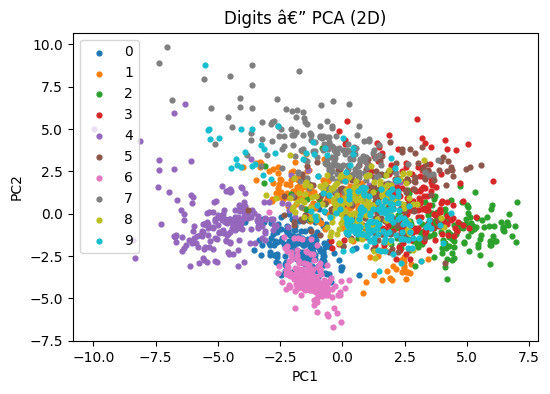

In [36]:
Z = StandardScaler().fit_transform(X_dig)
Z2 = PCA(n_components=2).fit_transform(Z)
plt.figure()
for c in np.unique(y_dig):
    pts = Z2[y_dig==c]
    plt.scatter(pts[:,0], pts[:,1], s=12, label=str(c))
plt.legend(); plt.title('Digits â€” PCA (2D)'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

### Digits â€” Modeling (Softmax)

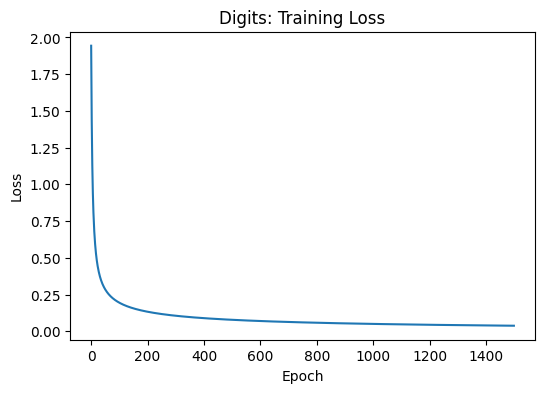

Digits accuracy (from scratch): 0.9689
[[45  0  0  0  0  0  0  0  0  0]
 [ 0 43  0  0  1  0  0  0  2  0]
 [ 0  0 44  0  0  0  0  0  0  0]
 [ 0  0  0 46  0  0  0  0  0  0]
 [ 0  0  0  0 44  0  0  0  0  1]
 [ 0  0  0  0  0 45  0  0  0  1]
 [ 0  0  0  0  0  0 44  0  1  0]
 [ 0  0  0  0  0  0  0 45  0  0]
 [ 0  4  0  0  0  0  0  1 38  0]
 [ 0  0  0  0  1  0  0  1  1 42]]


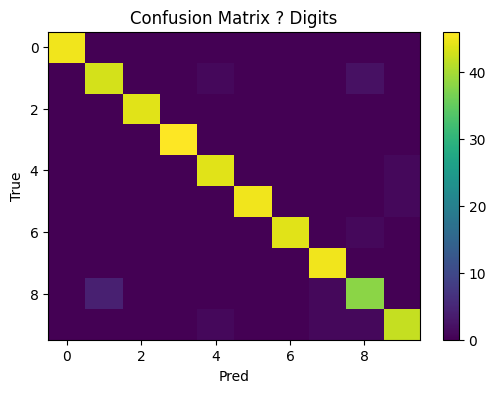

In [37]:
Xtr_d, Xva_d, ytr_d, yva_d = train_test_split(X_dig, y_dig, test_size=0.25, stratify=y_dig, random_state=42)
scaler_d = StandardScaler()
Xtr_d_std = scaler_d.fit_transform(Xtr_d)
Xva_d_std = scaler_d.transform(Xva_d)

# ------------------------------------------------
# TODO We will utilize the fit_softmax we defined in the first part, we will be using the Xtr_d_std as the train data (Exercise 11)
# lr=0.2, lam=0.001, epochs=1500 and verbose=False
# ------------------------------------------------
W_d, b_d, losses_d = fit_softmax(Xtr_d_std, ytr_d, lr=0.2, lam=0.001, epochs=1500, batch_size=None, verbose=False)
# ----------------------------
# Implementation Ends Here
# ----------------------------

if len(losses_d)>0:
    plt.figure(); plt.plot(losses_d); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Digits: Training Loss'); plt.show()
yp_d = predict_label_softmax(Xva_d_std, W_d, b_d)
print('Digits accuracy (from scratch):', round(accuracy_score(yva_d, yp_d),4))
cm = confusion_matrix(yva_d, yp_d); print(cm)
plt.figure(); plt.imshow(cm, aspect='auto'); plt.title('Confusion Matrix ? Digits'); plt.xlabel('Pred'); plt.ylabel('True'); plt.colorbar(); plt.show()


In [38]:

# ------------------------------------------------
# TODO We will be utilizing the LogisticRegression model from sklearn, we will use multinomial as the multi_class, lbfgs as the solver and the max_iter=2000 (Exercise 12)
# First we will train on our data Xtr_d_std
# After we want to do predictions on the validation set data Xva_d_std
# ------------------------------------------------

clf_d = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000)
clf_d.fit(Xtr_d_std, ytr_d)
preds_skl_d = clf_d.predict(Xva_d_std)
# ----------------------------
# Implementation Ends Here
# ----------------------------

print('sklearn (Digits) accuracy:', round(accuracy_score(yva_d, preds_skl_d),4))


sklearn (Digits) accuracy: 0.9778


c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


# **Questions and Answers** (10 points)


---

### **1. Sigmoid vs Softmax**  

Why do we use the sigmoid or softmax functions instead of a linear output?

**Answer:**


### **2. Separating Data** 

Why can Logistic Regression handle linearly separable data well, but struggle with non-linear data?

**Answer:**


### **3. Logistic vs Linear** 

Compare Logistic Regression with Linear Regression. In what cases can both models produce similar predictions?

**Answer:**

### **4. Discriminative Model** 

Explain why Logistic Regression is a discriminative model and not a generative one.

**Answer:**